# TP3 - Machine Learning for Time Series

Group 28

# Setup

In [ ]:
!pip install pygsp
!pip install loadmydata
!pip install geopandas
!pip install contextily

**Imports**

In [3]:
import time
import datetime as dt
from math import log
import IPython

import matplotlib.pyplot as plt
import numpy as np
!pip install ruptures
import ruptures as rpt
from scipy.signal import chirp, stft, sweep_poly

rng = np.random.default_rng()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Utility functions**

In [56]:
tones = {"1": (697, 1209), "2": (697, 1336), "3": (697, 1477), "4": (770, 1209), "5": (770, 1336), "6": (770, 1477), "7": (852, 1209), "8": (852, 1336), "9": (852, 1477), "0": (941, 1336), "*": (941, 1209), "#": (941, 1477), "A": (697, 1633), "B": (770, 1633), "C": (852, 1633), "D": (941, 1633)}
FS = 22_050  # Hz
durantion = 3
sigma = 2

def generate_symbol(symbol, duration, fs):
    """Generate the sound for number with given duration"""
    # get both frequencies for the symbol
    f1, f2 = tones[symbol]
    # time array
    time_arr = np.arange(0, duration, 1 / fs)
    # audio signal
    signal = np.cos(2 * np.pi * f1 * time_arr) + np.cos(2 * np.pi * f2 * time_arr)
    return signal

def generate_signal():
    n_symbols = rng.integers(3, 12)
    list_of_symbols = rng.choice(list("1234567890*#ABCD"), size=n_symbols)

    list_of_segments = list()

    for symbol in list_of_symbols:
        duration = rng.uniform(low=0.05, high=0.2)  # seconds
        # generate tone
        symbol_signal = generate_symbol(symbol=symbol, duration=duration, fs=FS)
        # generate silence
        silence = np.zeros(int(duration*FS))
        # append tone and silence
        list_of_segments.extend([symbol_signal, silence])

    # silence at the start
    silence = np.zeros(int(duration*FS))
    list_of_segments = [silence] + list_of_segments

    signal = np.concatenate(list_of_segments)
    n_samples = signal.shape[0]
    time_array = np.arange(n_samples) / FS
    
    # add nuissance
    inst_freq = np.sin(2 * np.pi * 1.2 * time_array) * 1500 + 2000
    poly = np.polyfit(x=time_array, y=inst_freq, deg=14)
    sin_freq = sweep_poly(time_array, poly)
    signal += sin_freq
    # add white noise
    signal += rng.normal(scale=sigma, size=n_samples)

    return signal, list_of_symbols.tolist()


# Question 1


[Dual-tone multi-frequency signaling](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling) is a procedure to encode symbols using audio signal.

A symbold is represented by a sum of cosine waves: for $t=0,1,\dots,T-1$,

$$
y_t = \cos(2\pi f_1 t/f_s) + \cos(2\pi f_2 t/f_s)
$$
where each combination of $(f_1, f_2)$ represents a symbols (see table below).


|         | 1209 Hz  | 1336 Hz  | 1477 Hz  | 1633 Hz  |
|---------|----------|----------|----------|----------|
| **697 Hz**  | 1        | 2        | 3        | A        |
| **770 Hz**  | 4        | 5        | 6        | B        |
| **852 Hz**  | 7        | 8        | 9        | C        |
| **941 Hz**  | *        | 0        | #        | D        |

In [57]:
!mkdir plots_q1

mkdir: cannot create directory ‘plots_q1’: File exists


In [58]:
signal, symbols = generate_signal()
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

8 7 # B # B 7 3 4


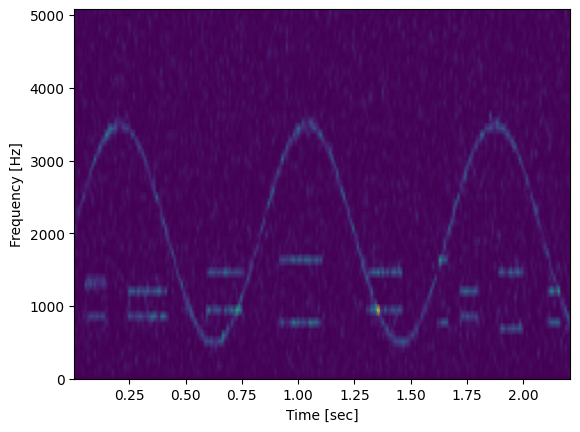

In [59]:
from scipy.signal import spectrogram


nperseg = 256
noverlap = nperseg // 8
f, t, Sxx = spectrogram(signal, FS, nperseg=nperseg, noverlap=noverlap)

plt.pcolormesh(t, f[0:60], Sxx[0:60,:], shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [60]:
pen_bic = 2 * sigma

In [ ]:
'''predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(
    signal=signal, pen=pen_bic
)'''

Tout d'abord, supposons le nombre de points de détection fixe.

In [63]:
n_bkps = 18
algo = rpt.Dynp(model="l2", jump=1).fit(signal = Sxx[0:100,:].T)
predicted_bkps = algo.predict(n_bkps=n_bkps)

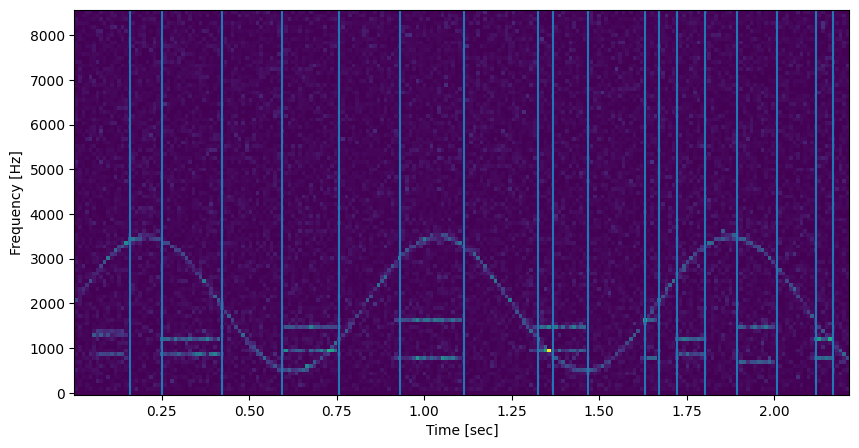

In [64]:
plt.figure(figsize=(10, 5))
plt.pcolormesh(t, f[0:100], Sxx[0:100,:])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

for b in predicted_bkps[:-1]:
    plt.axvline(t[b])

plt.savefig('plots_q1/pcolormesh.png')

Cherchons désormais à trouver une méthode adaptative. 

In [92]:
threshold_pixel = 0.002
threshold_mean_occup, threshold_mean_empty = 0.9, 0.25
n_bkps_to_try = np.arange(3, 100)
mean_occupation_all = []

start_time = time.time()

# iterate over values to try for n_bkps
for n_bkps in n_bkps_to_try:

  print(f'> Currently trying for n_bkps={n_bkps} !')
  occupation_empty, occupation_detected = [], []

  # make prediction on bkps
  algo = rpt.Dynp(model="l2", jump=1).fit(signal = Sxx[0:100,:].T)
  predicted_bkps = algo.predict(n_bkps=n_bkps)

  # iterate over predicted segments
  for i in range(0, len(predicted_bkps)):

    if(i==len(predicted_bkps)-1): # ignore last segment
      pass

    else:
      # get index of begining and end of the anomaly
      start_idx = predicted_bkps[i]
      end_idx = predicted_bkps[i+1]

      # find where the detected symbol is
      y_index_max = np.argmax(np.mean(Sxx[0:100,start_idx:end_idx], axis=1))

      # compute mean of occupation on this segment
      mean_occupation = np.mean(Sxx[y_index_max, start_idx:end_idx] > threshold_pixel)

      if(i%2==0):
        occupation_detected.append(mean_occupation)
      else:
        occupation_empty.append(mean_occupation)


  # compute overall mean
  mean_detected, mean_empty = np.mean(occupation_detected), np.mean(occupation_empty)
  print(f'  >> Mean detected: {mean_detected:.2f} - Mean empty: {mean_empty:.2f}')
  

  if((mean_detected > threshold_mean_occup) & (mean_empty < threshold_mean_empty)):
    exec_time = time.time() - start_time
    print(f'Optimal number found : {n_bkps} ! Execution time : {exec_time:.2f}')
    break


#print(f'Total mean occupation : {np.mean(mean_occupation_all)} !')


> Currently trying for n_bkps=3 !
  >> Mean detected: 0.75 - Mean empty: 0.36
> Currently trying for n_bkps=4 !
  >> Mean detected: 0.83 - Mean empty: 0.30
> Currently trying for n_bkps=5 !
  >> Mean detected: 0.72 - Mean empty: 0.34
> Currently trying for n_bkps=6 !
  >> Mean detected: 0.88 - Mean empty: 0.33
> Currently trying for n_bkps=7 !
  >> Mean detected: 0.86 - Mean empty: 0.49
> Currently trying for n_bkps=8 !
  >> Mean detected: 0.99 - Mean empty: 0.44
> Currently trying for n_bkps=9 !
  >> Mean detected: 0.55 - Mean empty: 0.92
> Currently trying for n_bkps=10 !
  >> Mean detected: 0.99 - Mean empty: 0.41
> Currently trying for n_bkps=11 !
  >> Mean detected: 0.45 - Mean empty: 0.92
> Currently trying for n_bkps=12 !
  >> Mean detected: 0.98 - Mean empty: 0.33
> Currently trying for n_bkps=13 !
  >> Mean detected: 0.43 - Mean empty: 0.95
> Currently trying for n_bkps=14 !
  >> Mean detected: 0.99 - Mean empty: 0.33
> Currently trying for n_bkps=15 !
  >> Mean detected: 0.36

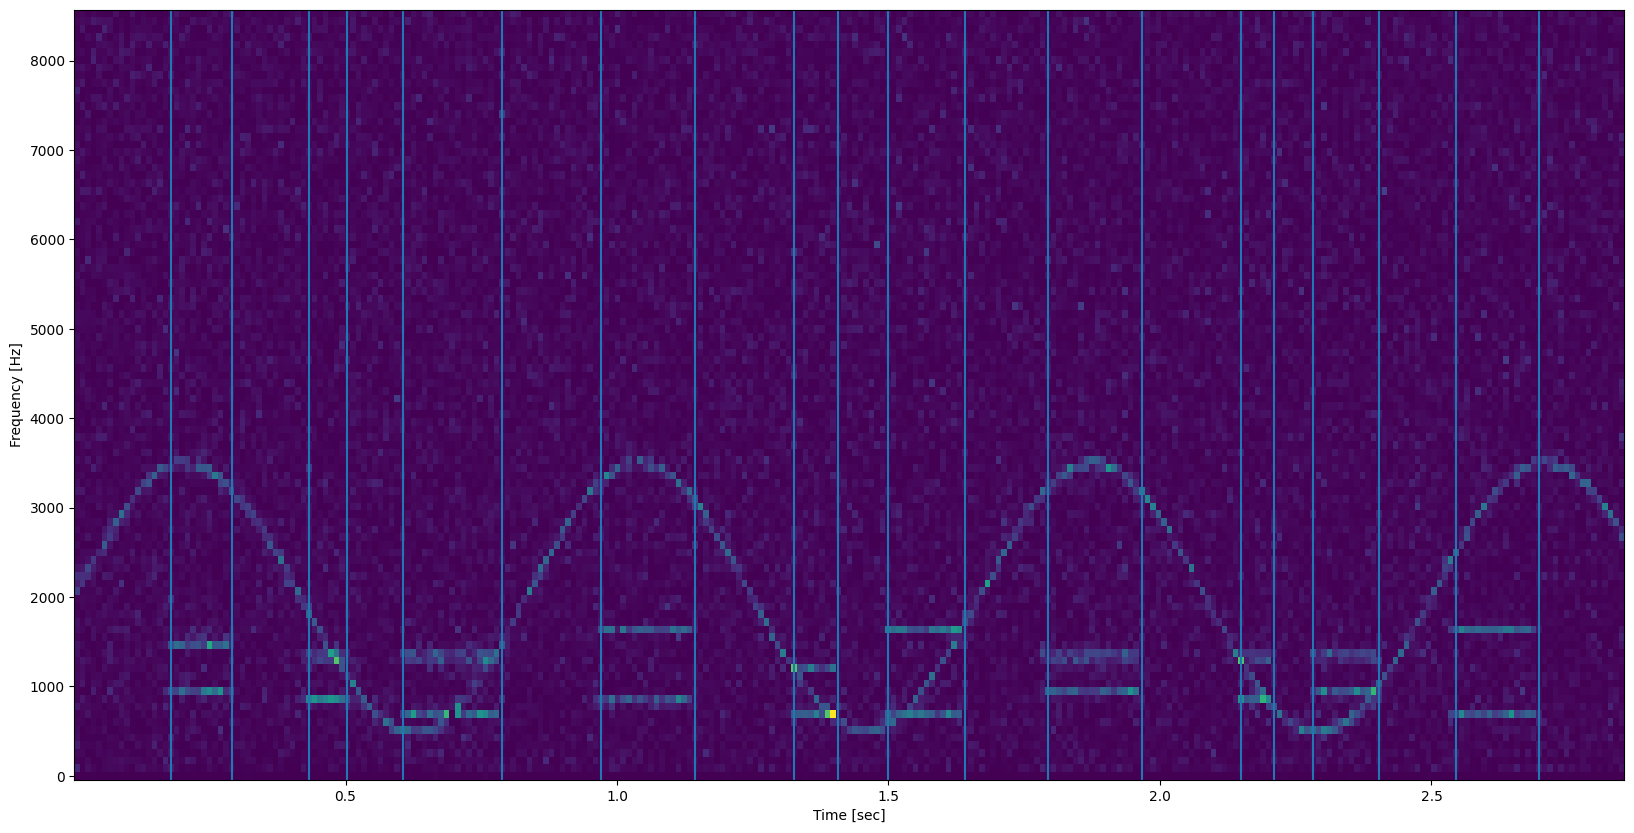

In [93]:
plt.figure(figsize=(20, 10))
plt.pcolormesh(t, f[0:100], Sxx[0:100,:])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

for b in predicted_bkps[:-1]:
    plt.axvline(t[b])

# Question 2

In [78]:
# load signals
sound_1 = np.loadtxt("signal_1.csv")
sound_2 = np.loadtxt("signal_2.csv")

print(f'Length of sound_1: {len(sound_1)}')
print(f'Length of sound_2: {len(sound_2)}')

Length of sound_1: 56629
Length of sound_2: 47031


## sound_1

In [79]:
from scipy.signal import spectrogram

FS = 22_050  # Hz
f, t, Sxx = spectrogram(sound_1, FS)

Text(0.5, 0, 'Time [sec]')

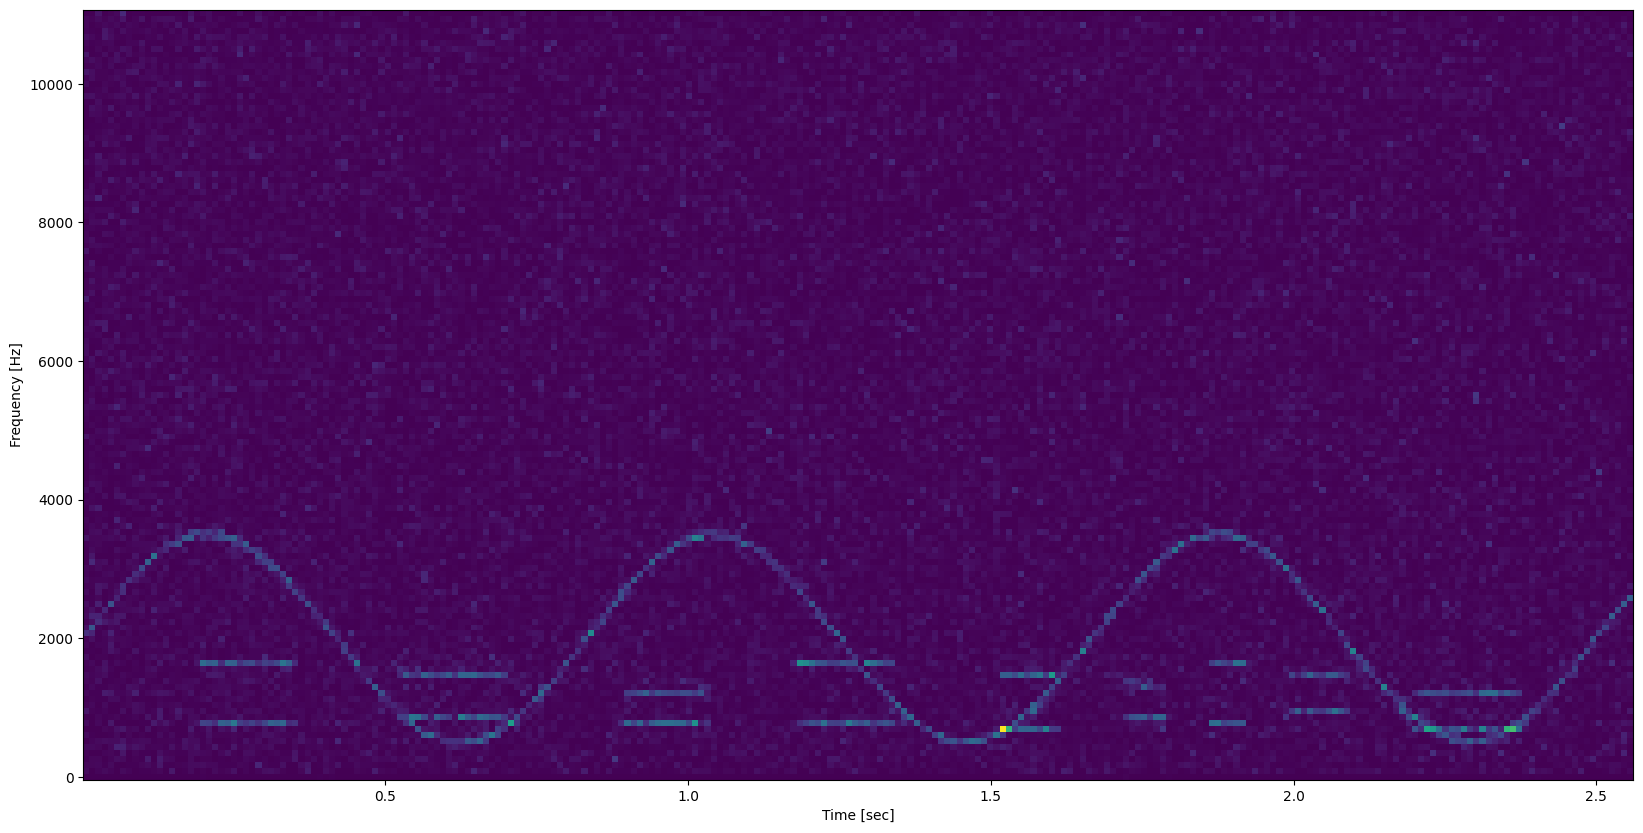

In [80]:
# displau tje spectogram
plt.figure(figsize=(20, 10))
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

In [81]:
# detect segments
n_bkps = 18
algo = rpt.Dynp(model="l2", jump=1).fit(signal = Sxx.T)
predicted_bkps = algo.predict(n_bkps=n_bkps)

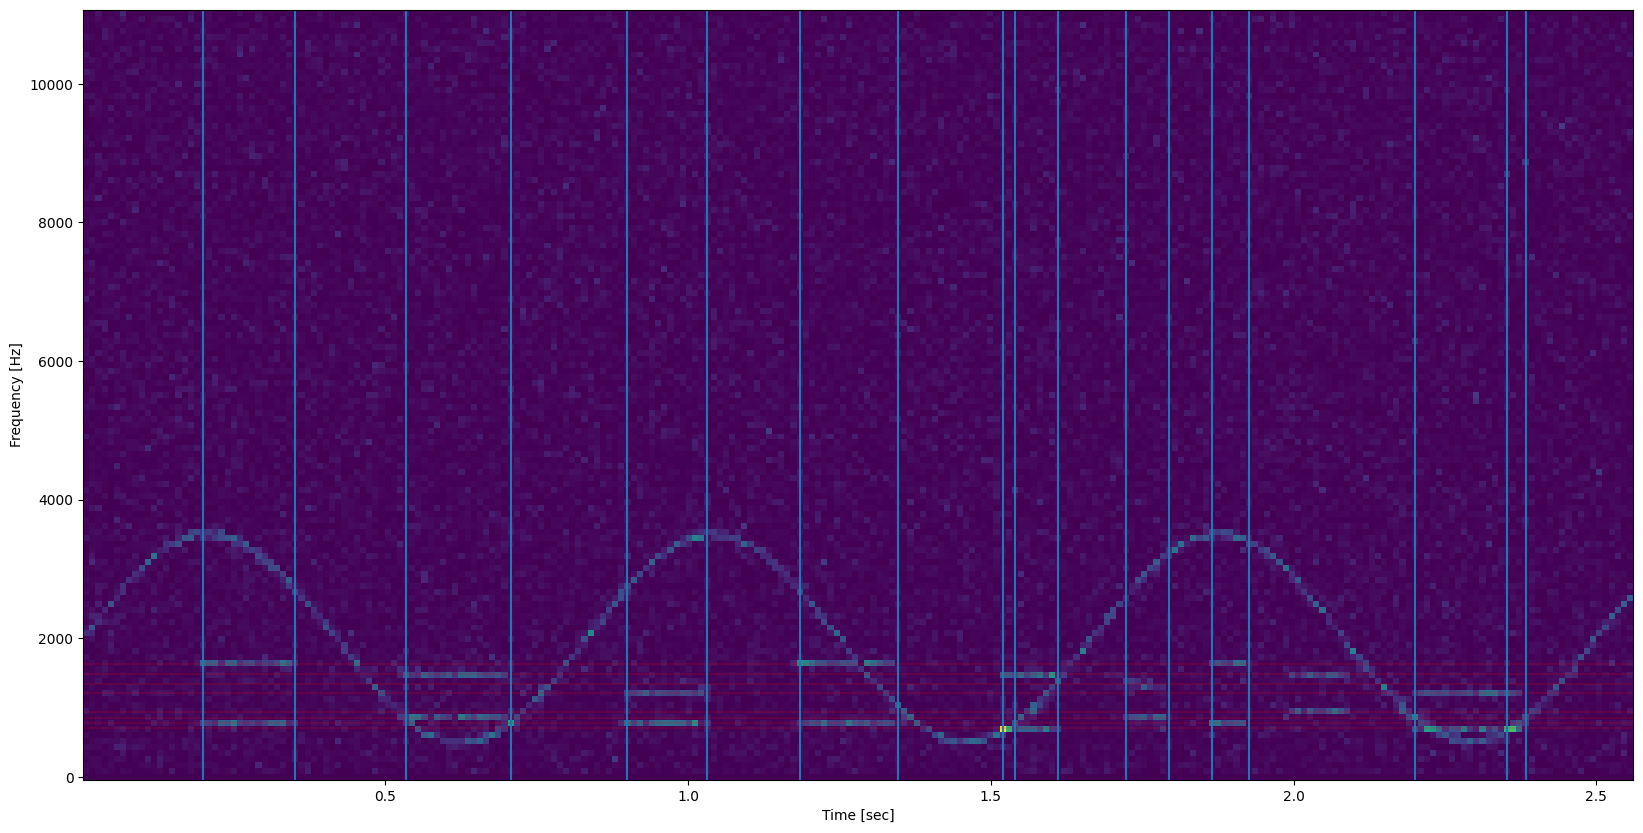

In [82]:
# display results with frequencies of symbols to find the code
plt.figure(figsize=(20, 10))
plt.pcolormesh(t, f, Sxx)
freqs_display = [697, 770, 852, 941, 1209, 1336, 1477, 1633]
for f_display in freqs_display:
  plt.axhline(y=f_display, c='r', alpha=0.15)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

for b in predicted_bkps[:-1]:
    plt.axvline(t[b])

The detections made by the algorithm are not all perfect, however we can see from table 1 which provides the symbols that the code is :    

Signal 1 : B94B68B#1

## sound_2

In [ ]:
# spectogram of the signal
f, t, Sxx = spectrogram(sound_2, FS)

Text(0.5, 0, 'Time [sec]')

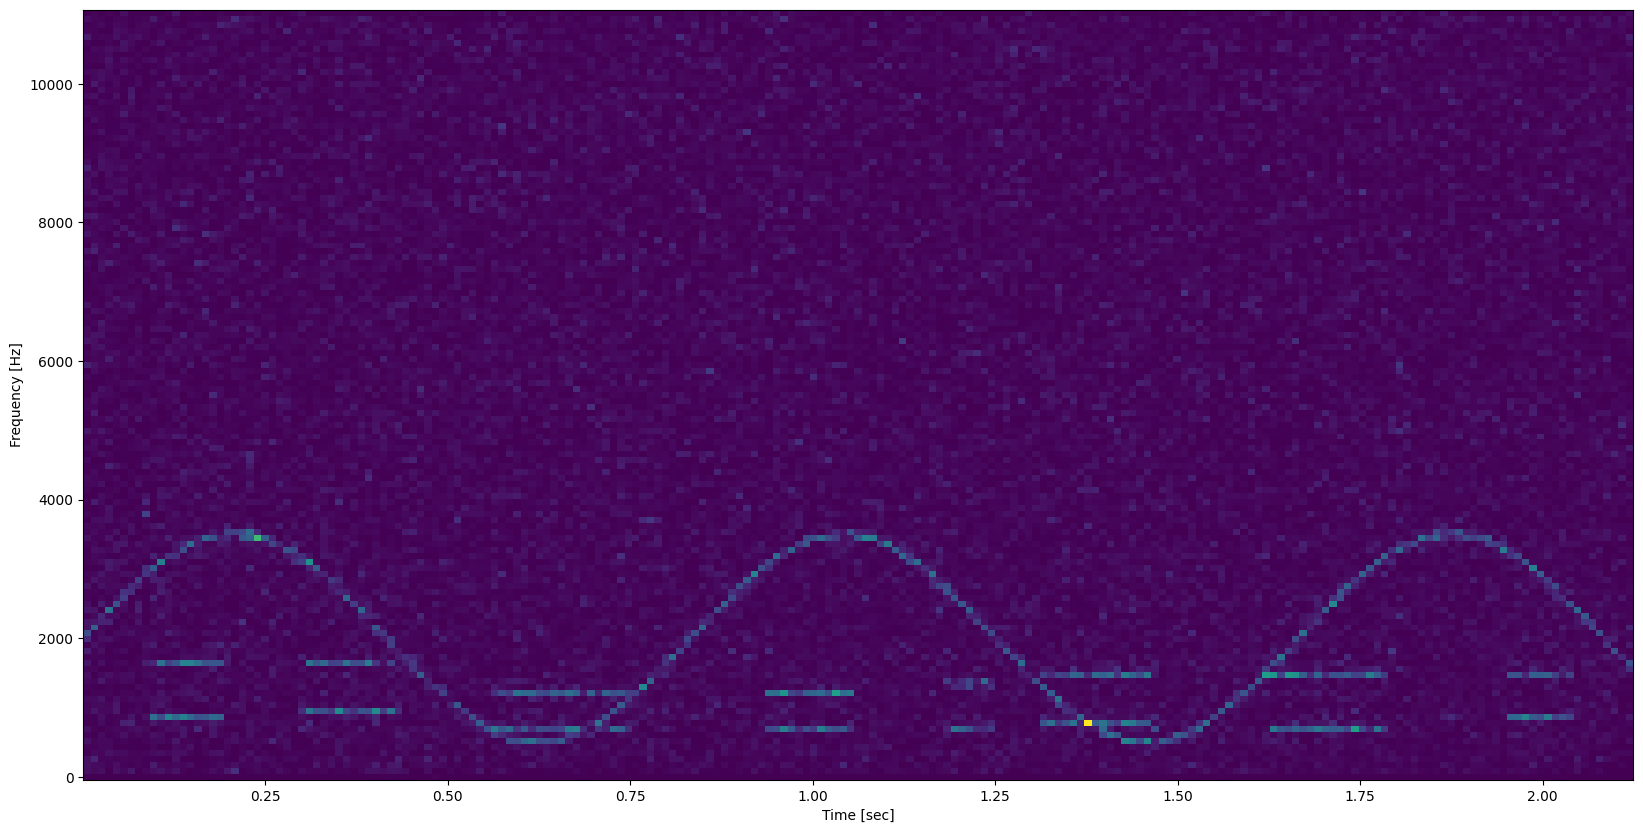

In [ ]:
plt.figure(figsize=(20, 10))
plt.pcolormesh(t, f, Sxx)
freqs_display = [697, 770, 852, 941, 1209, 1336, 1477, 1633]
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

In [ ]:
# detect symbols
n_bkps = 16
algo = rpt.Dynp(model="l2", jump=1).fit(signal = Sxx.T)
predicted_bkps = algo.predict(n_bkps=n_bkps)

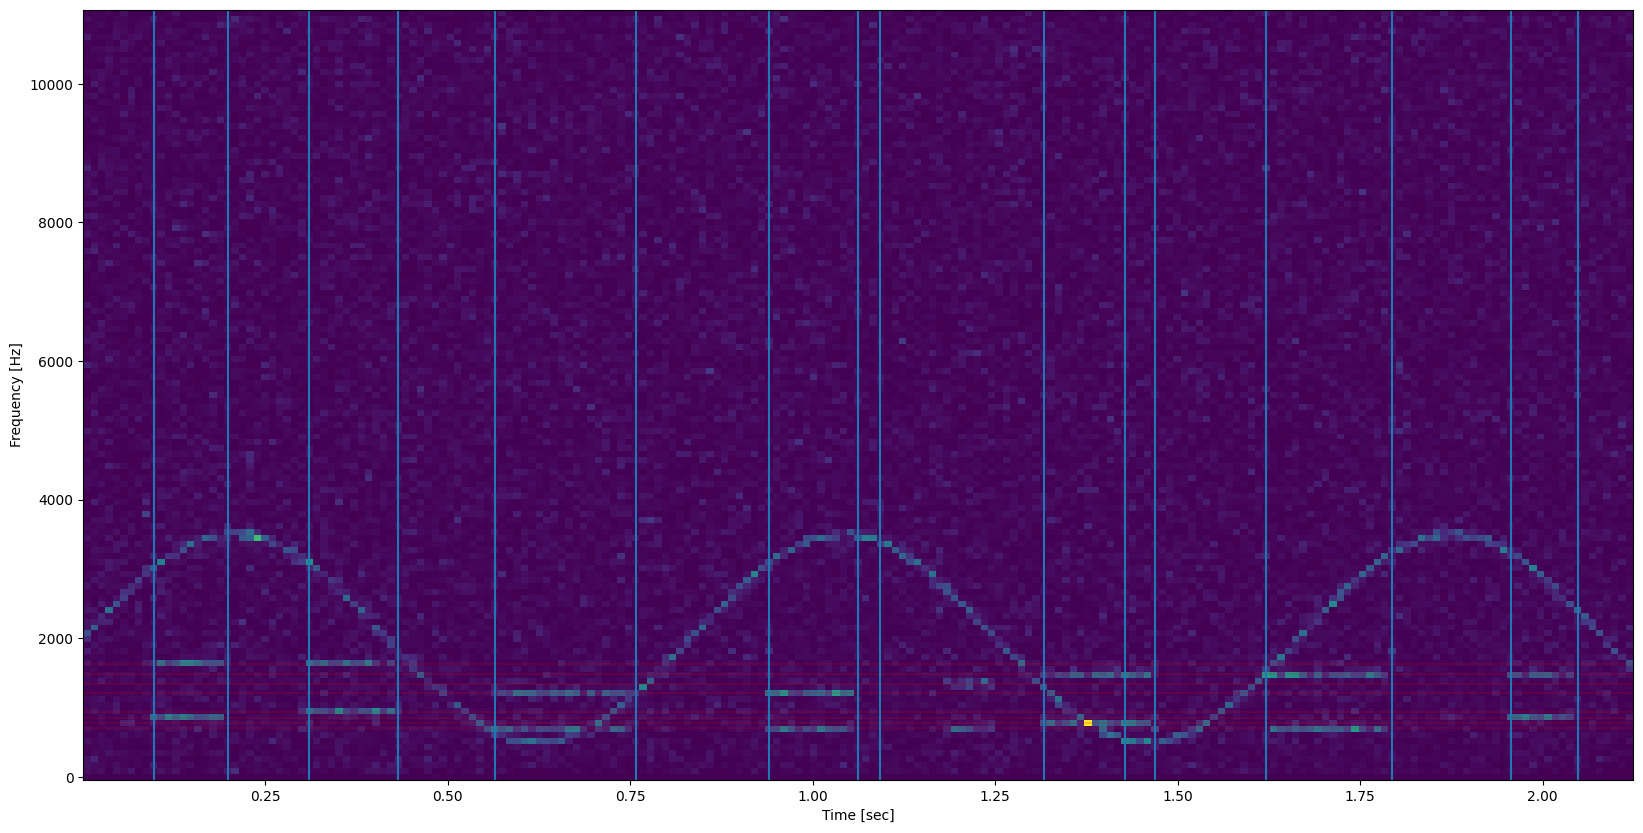

In [ ]:
# display results with frequencies of symbols to find the code
plt.figure(figsize=(20, 10))
plt.pcolormesh(t, f, Sxx)
freqs_display = [697, 770, 852, 941, 1209, 1336, 1477, 1633]
for f_display in freqs_display:
  plt.axhline(y=f_display, c='r', alpha=0.15)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

for b in predicted_bkps[:-1]:
    plt.axvline(t[b])

The detections made by the algorithm are not all perfect, however we can see from table 1 which provides the symbols that the code is :  

Signal 2 : CD112639

# Question 3

In [ ]:
!mkdir plots_q3

In [28]:
def get_g_m(eigenvalues, a, m, R):
  '''
  inputs:
    eigenvalues : eigenvalues of L
    a : translation value
    m : index of kernel function
    R : value defined by the user
  outputs:
    g_m : spectrum adapted graph wavelets (2) from subject
  '''
  # compute values of lambdas to compute g_U
  lambdas = eigenvalues - a*m
  # indicator function for bounds on lambdas
  indicator_flag = (lambdas < 0) & (lambdas >= -R*a)
  # compute g_U
  output = .5*(1 + np.cos(2*np.pi*(.5 + lambdas/(a*R))))*indicator_flag

  return output

In [ ]:
# initialize eigenvalues
lambda_max, eigenvalues_number = 10, 500
eigenvalues = np.linspace(0, lambda_max, eigenvalues_number)

# initialize number of scales M
M = 9

# initialize values for m
m_list = np.arange(1, M+1)

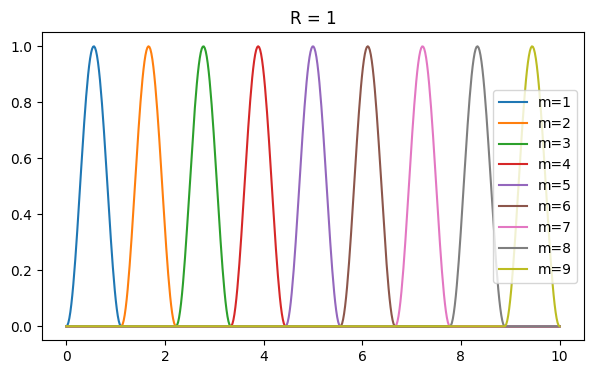

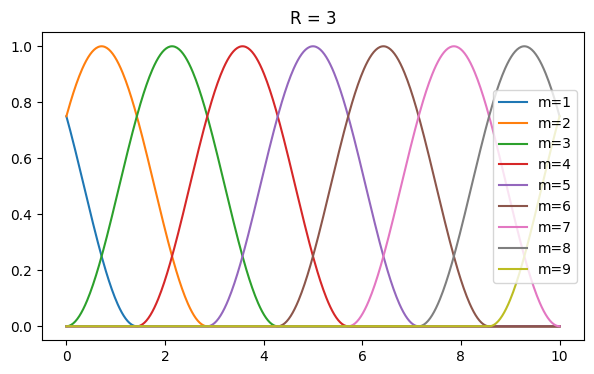

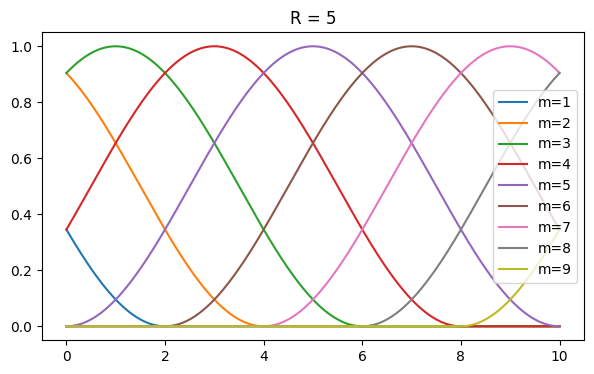

In [ ]:
# iterate over values for R
for R in [1, 3, 5]:
  plt.figure(figsize=(7, 4))
  
  # compute a
  a = eigenvalues[-1]/(M + 1 - R)

  # iterate over m
  for m in m_list:
      # compute g_m and display
      current_g_m = get_g_m(eigenvalues, a, m, R)
      plt.plot(eigenvalues, current_g_m, label=f'm={m}')

  plt.legend()
  plt.title(f'R = {R}')
  plt.savefig(f'plots_q3/R_{R}.png', bbox_inches='tight')
  plt.show()

# Question 4

In [6]:
!mkdir plots_q4

mkdir: cannot create directory ‘plots_q4’: File exists


To start, load the data

In [4]:
from loadmydata.load_molene_meteo import load_molene_meteo_dataset

In [5]:
# load data
data_df, stations_df, description = load_molene_meteo_dataset()

# convert temperature from Kelvin to Celsius
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius

data_df.head()

,numer_sta,date,date_insert,td,t,tx,tn,u,ux,un,...,vv,etat_sol,sss,n,insolh,ray_glo01,pres,pmer,station_name,temp
0,29293001,2014-01-01 00:00:00,2014-01-01 00:05:55,280.25,283.95,283.95,283.65,78.0,80.0,73.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,TREGUNC,10.8
1,29293001,2014-01-01 01:00:00,2014-01-01 01:05:59,280.35,284.05,284.05,283.95,78.0,79.0,74.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,TREGUNC,10.9
2,29293001,2014-01-01 02:00:00,2014-01-01 02:16:05,280.45,283.75,284.05,283.65,80.0,80.0,76.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,TREGUNC,10.6
3,29293001,2014-01-01 03:00:00,2014-01-01 03:06:09,279.85,283.95,283.95,283.25,76.0,82.0,75.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,TREGUNC,10.8
4,29293001,2014-01-01 04:00:00,2014-01-01 04:06:14,281.15,284.15,284.15,283.95,82.0,82.0,72.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,TREGUNC,11.0


In [7]:
import geopandas
import contextily as cx
CRS = "EPSG:4326"

# convert pandas df to geopandas df
stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry=geopandas.points_from_xy(
        stations_df.Longitude, stations_df.Latitude
    ),
).set_crs(CRS)

stations_gdf.head()

,Numéro,Nom,Latitude,Longitude,X (Lambert II étendu),Y (Lambert II étendu),Altitude,geometry
0,22016001,ILE-DE-BREHAT,48.855167,-3.004500,208083,2441852,25,POINT (-3.00450 48.85517)
1,22092001,KERPERT,48.404000,-3.147667,194096,2392507,281,POINT (-3.14767 48.40400)
2,22113006,LANNAERO,48.755333,-3.468667,173267,2433190,85,POINT (-3.46867 48.75533)
3,22135001,LOUARGAT,48.551667,-3.376833,178359,2410097,148,POINT (-3.37683 48.55167)
4,22147006,MERDRIGNAC,48.182667,-2.410833,247067,2364385,131,POINT (-2.41083 48.18267)


In [8]:
# pivot data_df to have multivariate time series
temperature_df = data_df.pivot(
    index="date", values="temp", columns="station_name"
)
temperature_df.head()

station_name,ARZAL,AURAY,BATZ,BEG_MEIL,BELLE ILE-LE TALUT,BIGNAN,BREST-GUIPAVAS,BRIGNOGAN,CAMARET,DINARD,...,SIBIRIL S A,SIZUN,SPEZET,ST BRIEUC,ST NAZAIRE-MONTOIR,ST-SEGAL S A,THEIX,TREGUNC,VANNES-MEUCON,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,9.7,10.3,NaN,NaN,11.3,7.1,9.7,NaN,NaN,6.8,...,7.4,8.5,8.3,7.5,9.0,9.0,9.3,10.8,8.5,9.7
2014-01-01 01:00:00,9.8,10.4,NaN,NaN,10.3,7.6,9.6,9.2,NaN,6.5,...,8.2,8.3,8.6,7.0,9.1,9.5,9.1,10.9,8.7,9.9
2014-01-01 02:00:00,9.7,10.0,NaN,NaN,11.2,7.7,9.1,9.4,NaN,6.5,...,8.5,8.5,8.6,7.5,9.5,9.4,9.4,10.6,8.8,9.6
2014-01-01 03:00:00,9.4,10.4,NaN,NaN,11.4,7.9,9.7,10.1,NaN,7.1,...,8.5,8.7,8.9,7.2,9.0,9.9,8.9,10.8,8.6,9.8
2014-01-01 04:00:00,9.8,10.8,NaN,NaN,11.4,8.8,9.8,10.2,NaN,7.6,...,9.1,9.1,9.4,7.6,9.5,10.0,9.6,11.0,9.2,10.2


## Remove stations with NaN

Now, let's find stations with missing values for temperature.

In [9]:
# extract names of stations with NA values
temp_na = temperature_df.isna().sum(axis=0).sort_values(ascending=False)
temp_na = temp_na[temp_na > 0]

# display stations with NaN values
temp_na.index.tolist()

['BATZ',
 'BEG_MEIL',
 'CAMARET',
 'PLOUGONVELIN',
 'RIEC SUR BELON',
 'ST NAZAIRE-MONTOIR',
 'PLOUAY-SA',
 'VANNES-MEUCON',
 'LANNAERO',
 'PLOUDALMEZEAU',
 'LANDIVISIAU',
 'SIZUN',
 'QUIMPER',
 'OUESSANT-STIFF',
 'LANVEOC',
 'ARZAL',
 'BREST-GUIPAVAS',
 'BRIGNOGAN']

In [10]:
# remove stations with NaN
to_remove = temp_na.index.tolist()
print(f'Before removing, number of stations : {stations_df.shape[0]}')
print(f'Number of stations to remove : {len(to_remove)}')
stations_df = stations_df[~stations_df.Nom.isin(to_remove)]
print(f'After removing, number of stations : {stations_df.shape[0]}')

Before removing, number of stations : 55
Number of stations to remove : 18
After removing, number of stations : 37


## Minimum threshold

In [11]:
# define geodesic distance to compute distance matrix
def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

def get_exponential_similarity(
    condensed_distance_matrix, bandwidth, threshold
):
    exp_similarity = np.exp(
        -(condensed_distance_matrix ** 2) / bandwidth / bandwidth
    )
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

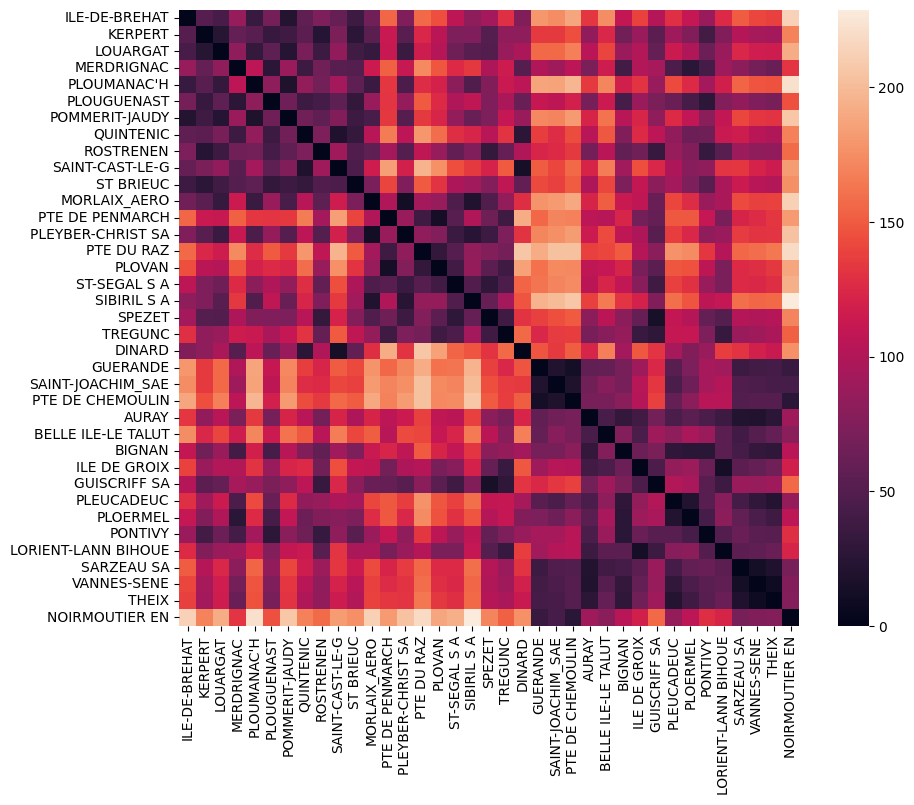

In [12]:
import seaborn as sns
from math import asin, cos, radians, sin, sqrt
from scipy.spatial.distance import pdist, squareform

# compute distant matrix
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

# display distant matrix
fig, ax = fig_ax((10, 8))
_ = sns.heatmap(dist_mat_square, xticklabels=stations_df.Nom, yticklabels=stations_df.Nom, ax=ax)

In [13]:
from pygsp import graphs

# median heuristic
sigma = np.median(dist_mat_condensed)
threshold_to_try = np.arange(0, 1, 1/100)

average_degrees, is_connected = [], []

# iterate over threshold to try
for threshold in threshold_to_try:

  # compute adjacency matrix with exponential smoothing
  adjacency_matrix_gaussian = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))

  # compute average degree per node
  average_degrees.append(np.mean(np.sum(adjacency_matrix_gaussian, axis=1)))

  # check if the graph is connected
  G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
  is_connected.append(G_gaussian.is_connected(recompute=True))

# select threshold which allows the graph to be connected AND with average degree at least 3
for index_to_try in np.where(np.array(average_degrees) > 3)[0][::-1]:
  if(is_connected[index_to_try]):
    print(f'> Select threshold: {threshold_to_try[index_to_try]:.2f} with average degree : {average_degrees[index_to_try]:.2f} !')
    threshold = threshold_to_try[index_to_try]
    average_degree = average_degrees[index_to_try]
    break

> Select threshold: 0.83 with average degree : 3.66 !


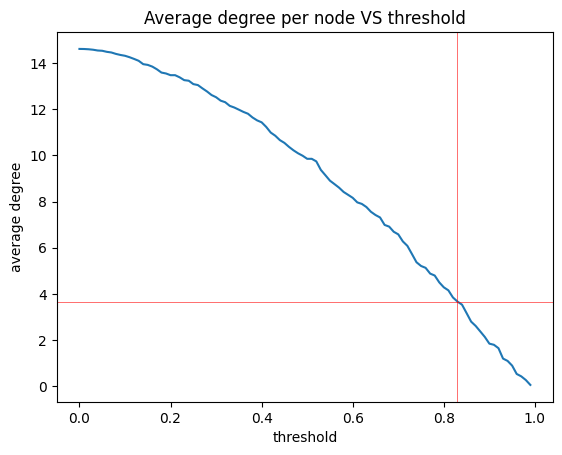

In [14]:
plt.plot(threshold_to_try, average_degrees)
plt.axvline(x = threshold, color = 'r', lw=0.4)
plt.axhline(y = average_degree, color = 'r', lw=0.4)
plt.title('Average degree per node VS threshold')
plt.xlabel('threshold'); plt.ylabel('average degree');

Then we look at where the signal is least smooth, and where it is smoothest.

## Smoothness of the signal

In [15]:
## remove stations with NaN from temperature_df
# all stations
all_stations = np.unique(data_df.station_name.tolist()).tolist()
# stations to keep
to_keep = list(set(all_stations) - set(to_remove))

# update temperature_df with stations to keep
temperature_df_tokeep = temperature_df[to_keep]

In [16]:
import pandas as pd

# compute adjacency matrix with exponential smoothing
adjacency_matrix_gaussian = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))

# compute average degree per node
G_gaussian = graphs.Graph(adjacency_matrix_gaussian)

# compute laplacian with chosen threshold
laplacian_matrix = G_gaussian.L.todense()

# compute smoothness
signals = temperature_df_tokeep.to_numpy()
smoothness_arr = np.array([float(signal.T.dot(laplacian_matrix).dot(signal)) for signal in signals])
smoothness_df = pd.Series(data=smoothness_arr, index=temperature_df_tokeep.index)

In [17]:
# find index for minimum and maximum smoothness
index_argmin = smoothness_df.argmin()
index_argmax = smoothness_df.argmax()

# display associated timestamp
print(f'Where the signal is the least smooth : {smoothness_df.index[index_argmax]}')
print(f'Where the signal is the smoothest : {smoothness_df.index[index_argmin]}')

Where the signal is the least smooth : 2014-01-21 02:00:00
Where the signal is the smoothest : 2014-01-24 19:00:00


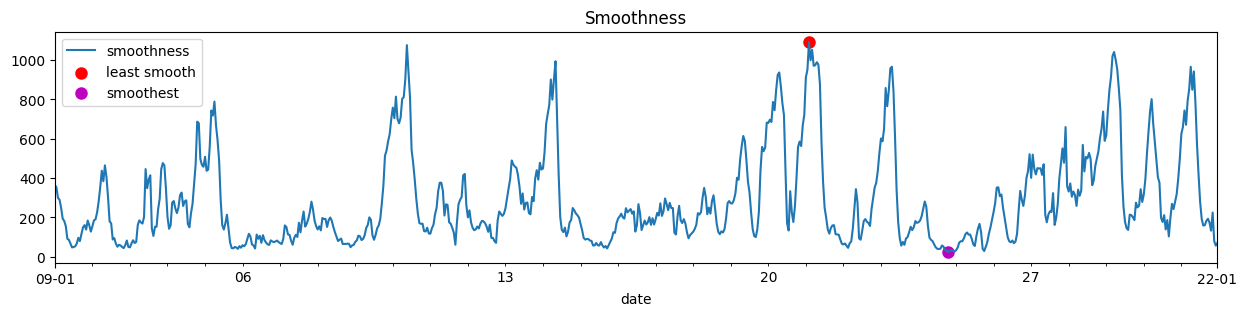

In [18]:
# display smoothness vs time
from matplotlib.dates import DateFormatter

fig, ax = fig_ax()
smoothness_df.plot(ax=ax, label='smoothness')
plt.scatter(smoothness_df.index[index_argmax], np.max(smoothness_df), c='r', label='least smooth', lw=3)
plt.scatter(smoothness_df.index[index_argmin], np.min(smoothness_df), c='m', label='smoothest', lw=3)
plt.legend()
myFmt = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(myFmt)
ax.set_title("Smoothness")
plt.grid(axis="x", color="0.95")
plt.savefig('plots_q4/smoothness.png', bbox_inches = 'tight')

Graph where the signal is the least smooth:


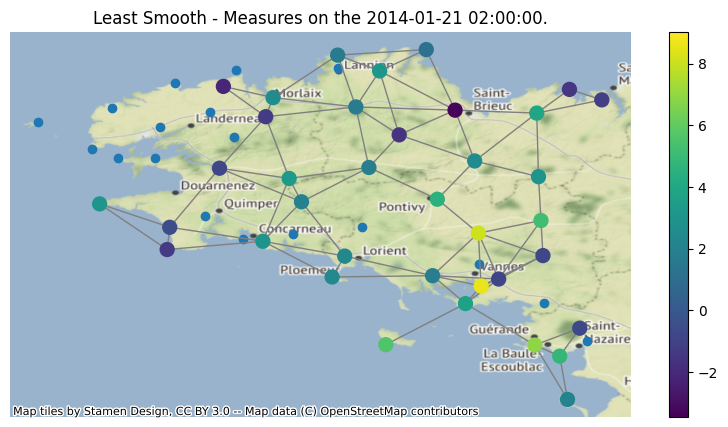


Graph where the signal is the smoothest:


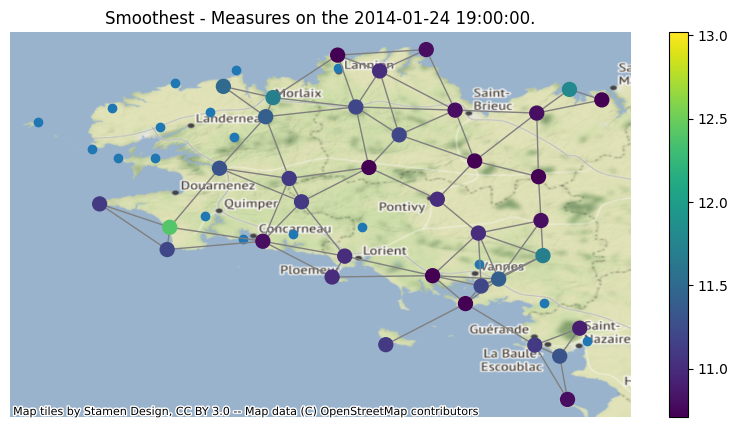

In [19]:
print(f'Graph where the signal is the least smooth:')
# display result for argmax
signal = temperature_df_tokeep.iloc[index_argmax].to_numpy()
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(signal, ax=ax)
_ = ax.set_title(f"Least Smooth - Measures on the {temperature_df_tokeep.index[index_argmax]}.")
plt.savefig('plots_q4/least_smooth.png')
plt.show()

# display result for argmin 
print(f'\nGraph where the signal is the smoothest:')
signal = temperature_df_tokeep.iloc[index_argmin].to_numpy()
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(signal, ax=ax)
_ = ax.set_title(f"Smoothest - Measures on the {temperature_df_tokeep.index[index_argmin]}.")
plt.savefig('plots_q4/smoothest.png')

# Question 5

It's needed to implement $W_f(m,v) = \sum_{l=1}^{n} \hat{g_m}(\lambda_l) \hat{f_l}u_l(v)$ where :

- $u_l(v)$ is $l^{th}$ eigenvector of L for node $v$.
- $f_l$ is the $l^{th}$ component of the Fourier transform of f.
- $\hat{g_m}$ is the SAGW.

In [20]:
!mkdir plots_q5

mkdir: cannot create directory ‘plots_q5’: File exists


In [21]:
temperature_df_tokeep.head()

station_name,QUINTENIC,VANNES-SENE,SAINT-JOACHIM_SAE,ROSTRENEN,DINARD,KERPERT,SPEZET,ILE-DE-BREHAT,PLOUGUENAST,PONTIVY,...,SARZEAU SA,GUERANDE,LORIENT-LANN BIHOUE,ILE DE GROIX,PLOUMANAC'H,POMMERIT-JAUDY,SAINT-CAST-LE-G,PTE DE PENMARCH,THEIX,PLEYBER-CHRIST SA
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,6.8,9.7,9.3,6.8,6.8,5.9,8.3,7.0,5.9,7.2,...,9.8,10.4,9.0,9.0,7.4,7.1,6.1,11.4,9.3,7.7
2014-01-01 01:00:00,6.7,9.9,9.3,6.9,6.5,5.9,8.6,7.0,6.2,8.1,...,9.9,10.6,10.0,10.0,7.8,7.6,6.3,11.5,9.1,7.8
2014-01-01 02:00:00,7.5,9.6,9.5,6.9,6.5,6.4,8.6,7.8,6.4,7.4,...,9.2,10.2,8.9,9.5,8.1,7.8,6.4,11.5,9.4,7.8
2014-01-01 03:00:00,7.8,9.8,9.0,7.3,7.1,6.7,8.9,8.3,6.9,8.1,...,10.1,10.6,10.1,10.4,8.4,8.3,7.0,11.4,8.9,8.0
2014-01-01 04:00:00,8.1,10.2,9.9,7.2,7.6,6.9,9.4,8.9,6.9,8.2,...,10.5,10.6,10.4,10.8,8.8,8.9,7.7,11.5,9.6,8.5


In [22]:
# check if Laplacian is indeed symmetric
rtol=1e-05
atol=1e-08
flag_sym = np.allclose(laplacian_matrix, laplacian_matrix.T, rtol=rtol, atol=atol)
print(f'Laplacian Matrix is {"symmetric" if flag_sym else "not symmetric"} !')

Laplacian Matrix is symmetric !


In [23]:
import scipy

# compute Laplacian matrix
adjacency_matrix_gaussian = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))
G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
laplacian_matrix = G_gaussian.L.todense()
# compute eigenvalues and eigenvectors
# using eigh instead of eig since L is hermitian
eigenvalues, eigenvectors = scipy.linalg.eigh(laplacian_matrix) 
#eigenvalues = np.real(eigenvalues)

In [24]:
# sort eigenvalues and eigenvectors
index_sort = np.argsort(eigenvalues)
eigenvalues = eigenvalues.real[index_sort]
eigenvectors = eigenvectors[:, index_sort]

In [25]:
# initialize R, M and a parameters
R = 3
M = 9
m_list = np.arange(1, M+1)
a = eigenvalues[-1]/(M + 1 - R)

In [26]:
# select signal that corresponds to the first timestamp available
signal = np.array(temperature_df_tokeep.loc[temperature_df_tokeep.index[0]])

# compute FT
signal_ft = eigenvectors.T @ signal

### First available timestamp

In [29]:
# select signal that corresponds to the first timestamp available
signal = np.array(temperature_df_tokeep.loc[temperature_df_tokeep.index[0]])

# compute FT
signal_ft = eigenvectors.T @ signal

labels = []

# iterate over each node
for v in range(signal.shape[0]):

  W_v = []

  # iterate over m
  for m in m_list:
    # https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html
    # eig[, i] is i-th eigenvector hence eig[v,] is all eigenvectors for node v
    W_v_m = np.sum(get_g_m(eigenvalues, a, m, R)*signal_ft*eigenvectors[v, :])
    W_v.append(W_v_m)

  # label for node v
  labels.append(np.argmax([np.sum(np.array(W_v[:3])**2), np.sum(np.array(W_v[3:6])**2), np.sum(np.array(W_v[6:9])**2)]))

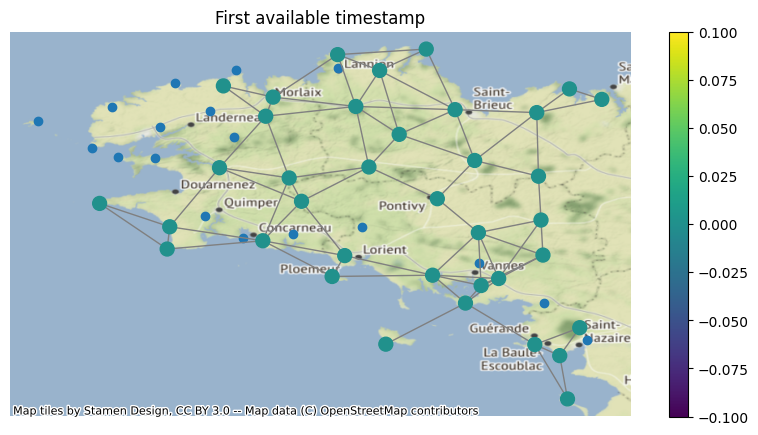

In [30]:
# display on the map the results
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(np.array(labels), ax=ax)
_ = ax.set_title(f"First available timestamp")

plt.savefig('plots_q5/map_firstsample.png')

## Smoothest signal

In [31]:
# select signal that corresponds to the first timestamp available
signal = np.array(temperature_df_tokeep.loc[temperature_df_tokeep.index[smoothness_df.argmin()]])

# compute FT
signal_ft = eigenvectors.T @ signal

labels = []

# iterate over each node
for v in range(signal.shape[0]):

  W_v = []

  # iterate over m
  for m in m_list:
    W_v_m = np.sum(get_g_m(eigenvalues, a, m, R)*signal_ft*eigenvectors[v, :])
    W_v.append(W_v_m)

  # label for node v
  labels.append(np.argmax([np.sum(np.array(W_v[:3])**2), np.sum(np.array(W_v[3:6])**2), np.sum(np.array(W_v[6:9])**2)]))

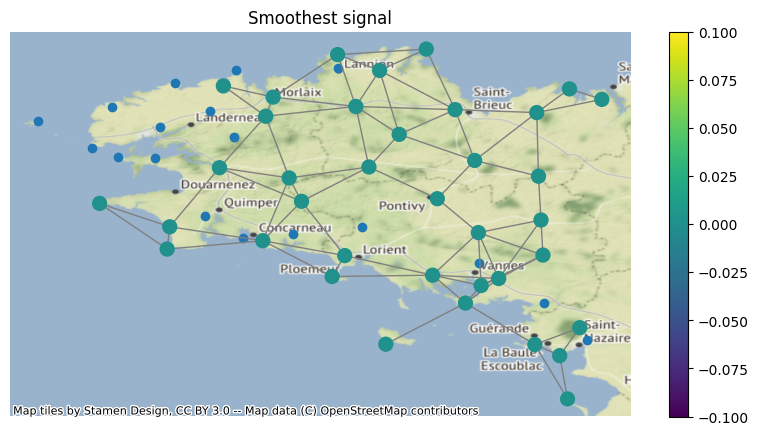

In [32]:
# display on the map the results
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(np.array(labels), ax=ax)
_ = ax.set_title(f"Smoothest signal")

plt.savefig('plots_q5/map_smoothest.png')

## Least smooth signal

In [33]:
# select signal that corresponds to the first timestamp available
signal = np.array(temperature_df_tokeep.loc[temperature_df_tokeep.index[smoothness_df.argmax()]])

# compute FT
signal_ft = eigenvectors.T @ signal

labels = []

# iterate over each node
for v in range(signal.shape[0]):

  W_v = []

  # iterate over m
  for m in m_list:
    W_v_m = np.sum(get_g_m(eigenvalues, a, m, R)*signal_ft*eigenvectors[v, :])
    W_v.append(W_v_m)

  # label for node v
  labels.append(np.argmax([np.sum(np.array(W_v[:3])**2), np.sum(np.array(W_v[3:6])**2), np.sum(np.array(W_v[6:9])**2)]))

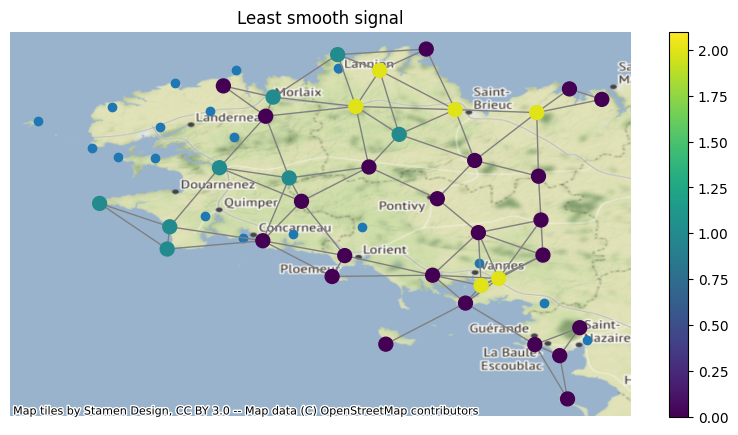

In [34]:
# display on the map the results
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(np.array(labels), ax=ax)
_ = ax.set_title(f"Least smooth signal")

plt.savefig('plots_q5/map_leastsmooth.png')

# Question 6

In [35]:
!mkdir plots_q6

mkdir: cannot create directory ‘plots_q6’: File exists


First, we define the function **get_freq_lab** which returns the majority class.

In [36]:
import collections

def get_freq_label(timestamp_index):
    '''
    from a given timestamp index
    return majority class@ky
    '''
    # select signal that corresponds to the first timestamp available
    signal = np.array(temperature_df_tokeep.loc[temperature_df_tokeep.index[timestamp_index]])

    # compute FT
    signal_ft = eigenvectors.T @ signal

    labels = []

    # iterate over each node
    for v in range(signal.shape[0]):

      W_v = []

      # iterate over m
      for m in m_list:
        #W_v.append(np.sum(get_g_m(eigenvalues, a, m, R)*signal_ft*eigenvectors[v, :]))
        W_v_m = np.sum(get_g_m(eigenvalues, a, m, R)*signal_ft*eigenvectors[v, :])
        W_v.append(W_v_m)

      # label for node v
      labels.append(np.argmax([np.sum(np.array(W_v[:3])**2), np.sum(np.array(W_v[3:6])**2), np.sum(np.array(W_v[6:9])**2)]))
      # compute occurences of each label
      count_labels = collections.Counter(labels)
      # get majority class
      majority_class = np.argmax([x[1] for x in count_labels.items()])

    return majority_class

In [37]:
class_array = []

# iterate over index
for idx_timestamp in range(temperature_df_tokeep.shape[0]):

    class_array.append(get_freq_label(idx_timestamp))

In [38]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.margins(x=0)
    return fig, ax

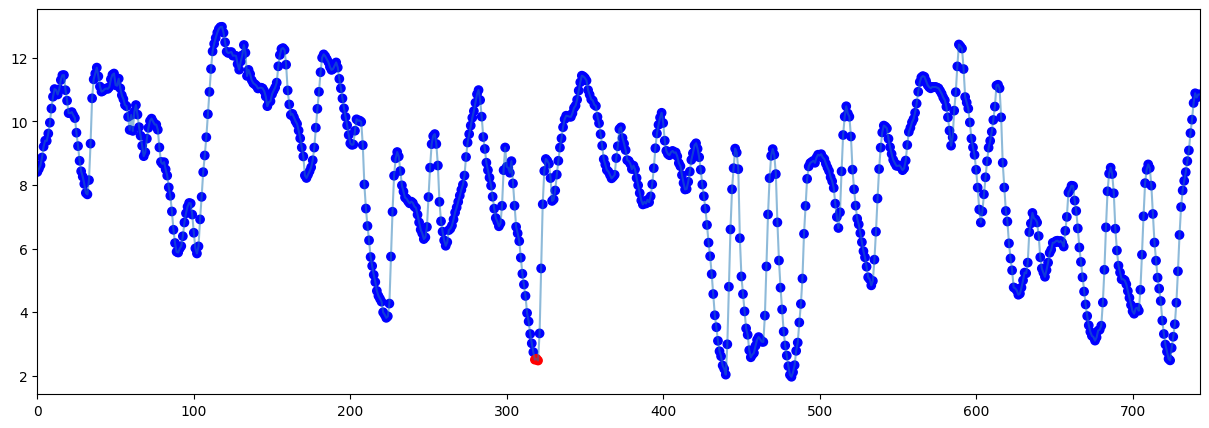

In [39]:
y = temperature_df_tokeep.mean(axis=1)
x = np.arange(y.shape[0])

colors = ["b", "m", "r"]  # three colours=three classes
color_array = np.take(colors, class_array)
fig, ax = fig_ax()
ax.plot(x, y, alpha=0.5)
ax.scatter(x, y, c=color_array)

plt.savefig('plots_q6/temp_q6.png', bbox_inches = 'tight')

# Question 7

In [40]:
!mkdir plots_q7

mkdir: cannot create directory ‘plots_q7’: File exists


In [41]:
print(f'Shape of the signal : {signals.shape}')

Shape of the signal : (744, 37)


In [42]:
# first step is to compute eigenvalues and eigenvectors of Laplacian
nb_nodes, dim_t  = signals.shape

# spacial dependency
eigenvalues, eigenvectors= scipy.linalg.eigh(G_gaussian.L.todense())
eigenvectors = eigenvectors.astype(np.float32)
# temp dependency
Lap_t =  - np.eye(nb_nodes, nb_nodes, 1) - np.eye(nb_nodes, nb_nodes, 1).T + np.eye(nb_nodes)
Lap_t[1:-1, 1:-1] = np.eye(nb_nodes - 2) + Lap_t[1:-1, 1:-1]
eigenvalues_time, eigenvectors_time = scipy.linalg.eigh(Lap_t)
eigenvectors_time = eigenvectors_time.astype(np.float32)

In [51]:
# second step is to compute eigenvalues and eigenvectors for the graph H as explain in the report
eigenvalues_H = np.kron(eigenvalues_time, np.ones(dim_t)) + np.kron(np.ones(nb_nodes), eigenvalues)
eigenvectors_H = np.kron(eigenvectors_time, eigenvectors)

# compute FT
signal_ft = eigenvectors_H.T @ signals.flatten()

In [52]:
labels = []
M, R = 11, 3
a = eigenvalues_H[-1]/(M + 1 - R)

# iterate over each node
for v in range(nb_nodes*dim_t):

  W_v = []

  # iterate over m
  for m in m_list:
    # https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html
    # eig[, i] is i-th eigenvector hence eig[v,] is all eigenvectors for node v
    W_v_m = np.sum(get_g_m(eigenvalues_H, a, m, R)*signal_ft*eigenvectors_H[v, :])
    W_v.append(W_v_m)

  # label for node v
  labels.append(np.argmax([np.sum(np.array(W_v[:3])**2), np.sum(np.array(W_v[3:6])**2), np.sum(np.array(W_v[6:9])**2)]))

In [53]:
assert len(labels) == nb_nodes*dim_t

# reshape to find the most occurent per node
labels_per_node = np.array(labels).reshape((nb_nodes, dim_t))
class_array = np.zeros(labels_per_node.shape[0])
for i, labels_current in enumerate(labels_per_node):
  # compute occurences of each label
    count_labels = collections.Counter(labels_current)
    # get majority class
    majority_class = np.argmax([x[1] for x in count_labels.items()])
    class_array[i] = majority_class

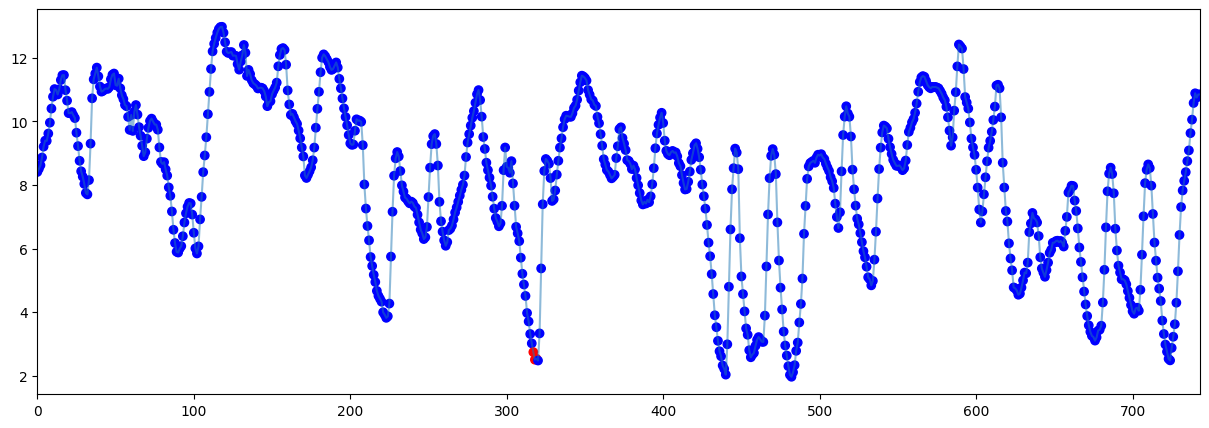

In [54]:
y = temperature_df_tokeep.mean(axis=1)
x = np.arange(y.shape[0])

colors = ["b", "m", "r"]  # three colours=three classes
color_array = np.take(colors, list(class_array))
fig, ax = fig_ax()
ax.plot(x, y, alpha=0.5)
ax.scatter(x, y, c=color_array)

plt.savefig('plots_q7/temp_q7.png', bbox_inches = 'tight')